In [384]:
import json
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
def load_df(csv_path='train.csv', nrows=None) -> pd.DataFrame:
    """
        JSON 형태로 되어있는 컬럼들을 모아서 DataFrame형태로 바꾸는 함수
        converters : JSON 컬럼들의 값들을 json_loads로 데이터 프레임화 시키는 함수를 적용하는 파라미터
        dtype : 데이터를 불러올 때 fullVisitorId의  dtype을 미리 str로 정의
        nrows :  limit와 같은 존재 너무 크면 오래걸리니까 2만으로 줄임.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    '''
    normalize는 json을 정규화(평평하게)만드는 것이며 이는 중첩된 구조를 하나의 테이블로 펼쳐서, 각각의 요소를 행으로 나타내는 것
    흔히 우리가 아는 테이블의 형태로 나타나게 된다. 
    새로운 컬럼을 for문을 통해서 각 column마다 서브 column name으로 할당
    정규화 되기 전 컬럼은 삭제하고, 새로운 컬럼으로 덮어씌운다.
    '''
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

df = load_df(nrows=200000)

## DROP

In [385]:
drop_columns = ['socialEngagementType', 'device_browser', 'device_browserVersion', 'device_browserSize', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_networkDomain', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent']
df =df.drop(drop_columns,axis=1)

## 전처리
### str 변환 함수

In [386]:
def transform_str (df:pd.DataFrame)-> pd.DataFrame:
    """
        str 형태로 변환하는 함수
    """
    transform_str_columns = ['fullVisitorId','sessionId','visitId']
    df[transform_str_columns]=df[transform_str_columns].astype(str)
    return df

transform_str(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               200000 non-null  object
 1   date                                          200000 non-null  int64 
 2   fullVisitorId                                 200000 non-null  object
 3   sessionId                                     200000 non-null  object
 4   visitId                                       200000 non-null  object
 5   visitNumber                                   200000 non-null  int64 
 6   visitStartTime                                200000 non-null  int64 
 7   device_isMobile                               200000 non-null  bool  
 8   device_deviceCategory                         200000 non-null  object
 9   geoNetwork_continent                          200000 non-nu

In [387]:
df['date'] =pd.to_datetime(df['date'])
df['visitStartTime']=pd.to_datetime(df['visitStartTime'],unit='s')

In [388]:
df.visitStartTime.isna().sum()

0

### str->int 변환 함수
-  totals_visits은 1로만 차있는 데이터라서 변환이 필요 없음.

In [389]:
def change_numeric(df:pd.DataFrame)-> pd.DataFrame :
    '''
        결측치를 처리하고 문자열-> int형으로 형변환하는 함수
    '''
    transform_int_columns = ['totals_hits','totals_pageviews','totals_bounces','totals_newVisits','totals_transactionRevenue']
    df[transform_int_columns]=df[transform_int_columns].fillna(0)
    df[transform_int_columns]= np.int64(df[transform_int_columns])
    return df 
    
df=change_numeric(df)
df.describe()


,date,visitNumber,visitStartTime,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue
count,200000,200000.00000,200000,200000.000000,200000.000000,200000.000000,200000.00000,2.000000e+05
mean,1970-01-01 00:00:00.020165291,2.24101,2017-01-12 23:25:42.176180224,4.503975,3.773320,0.496400,0.78424,1.667208e+06
min,1970-01-01 00:00:00.020160805,1.00000,2016-08-05 07:00:08,1.000000,0.000000,0.000000,0.00000,0.000000e+00
25%,1970-01-01 00:00:00.020161030,1.00000,2016-10-30 17:49:52.500000,1.000000,1.000000,0.000000,1.00000,0.000000e+00
50%,1970-01-01 00:00:00.020161209,1.00000,2016-12-09 15:54:11,2.000000,2.000000,0.000000,1.00000,0.000000e+00
75%,1970-01-01 00:00:00.020170412,1.00000,2017-04-12 09:33:28.249999872,4.000000,3.000000,1.000000,1.00000,0.000000e+00
max,1970-01-01 00:00:00.020170801,389.00000,2017-08-02 06:59:53,500.000000,400.000000,1.000000,1.00000,5.498000e+09
std,NaN,9.19020,NaN,9.502970,6.907599,0.499988,0.41135,3.402496e+07


### bounces

Text(1, 100001, '99280')

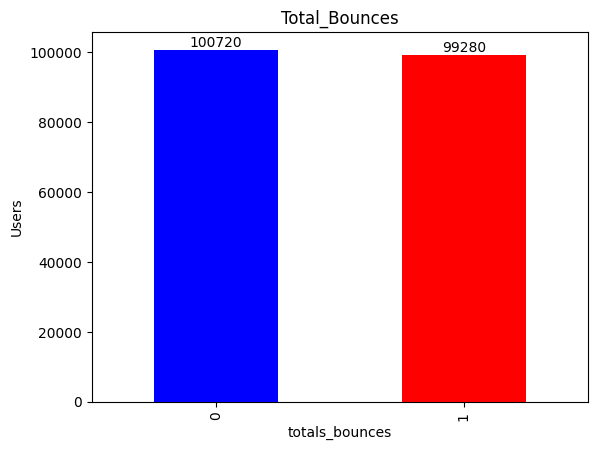

In [432]:
df_totals_bounces_count=df['totals_bounces'].value_counts()
df_totals_bounces_count.plot.bar(color=['blue','red'])
plt.ylabel('Users')
plt.title('Total_Bounces')
plt.text(0, df.totals_bounces[0]+101500 , f"{df_totals_bounces_count[0]}",ha='center')
plt.text(1, df.totals_bounces[0]+100000 , f"{df_totals_bounces_count[1]}",ha='center')

### Revenue

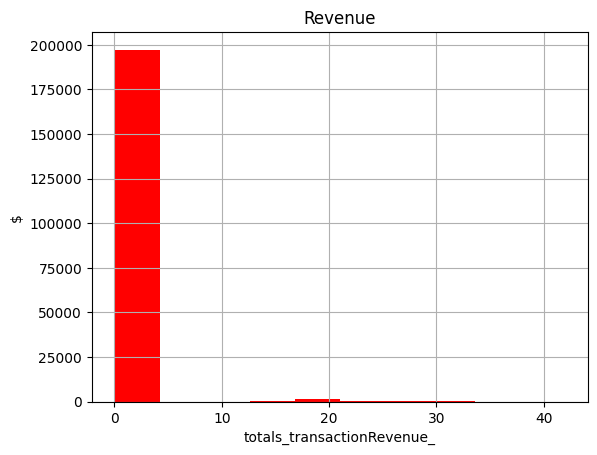

In [391]:
totals_transactionRevenue_median = df[df['totals_transactionRevenue'] != 0]['totals_transactionRevenue'].median()

df['totals_transactionRevenue'] = df['totals_transactionRevenue'].fillna(totals_transactionRevenue_median)

df['totals_transactionRevenue']=np.power(df['totals_transactionRevenue'],1/6).round(2)

df['totals_transactionRevenue'].hist(color='red')
plt.xlabel('totals_transactionRevenue_')
plt.ylabel('$')
plt.title('Revenue')
plt.show()

### ChannelGrouping

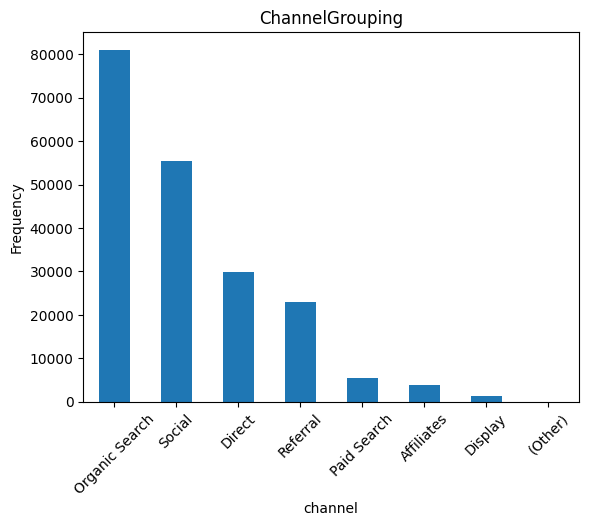

In [392]:
df.channelGrouping.value_counts().plot.bar()
plt.xlabel('channel')
plt.ylabel('Frequency')
plt.title('ChannelGrouping')
plt.xticks(rotation=45)
plt.show()

### GeoNetwork_continent

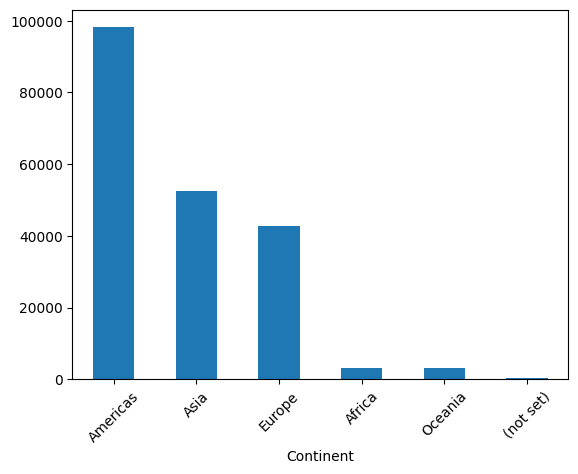

In [393]:
df.geoNetwork_continent.value_counts().plot.bar()
plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.show()

In [394]:
result_df = df.groupby(df['channelGrouping'])['trafficSource_source'].value_counts().sort_values(ascending=False)
result_df

channelGrouping  trafficSource_source
Organic Search   google                  79704
Social           youtube.com             52858
Direct           (direct)                29900
Referral         mall.googleplex.com     14761
Paid Search      google                   5401
                                         ...  
Referral         google.com.ph               1
                 google.com.mx               1
                 google.com.co               1
                 google.co.kr                1
Social           web.facebook.com            1
Name: count, Length: 207, dtype: int64

### DAU

Text(0.5, 1.0, 'Day Active Users(DAU)')

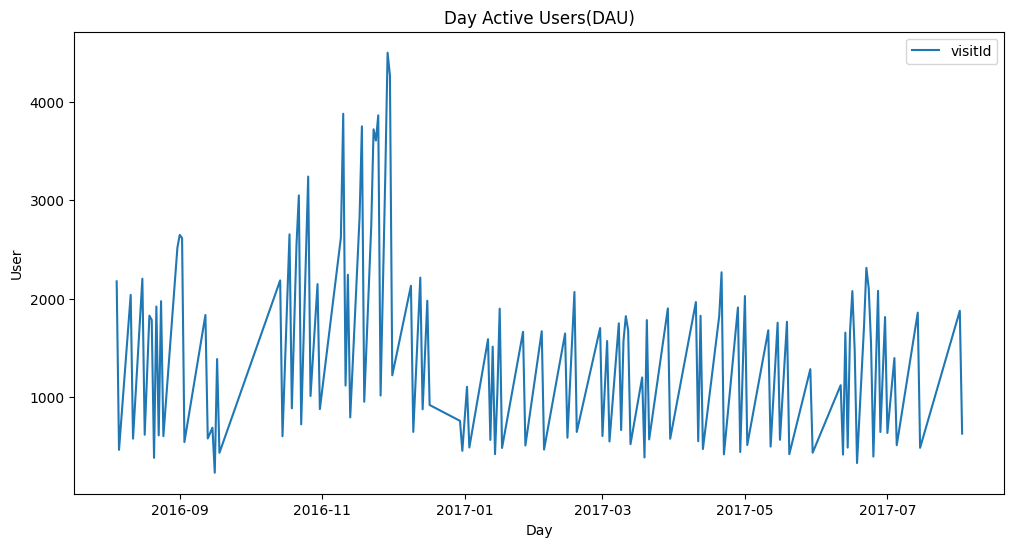

In [422]:
df['date_of_Day']=df.visitStartTime.dt.date
df_DAU=df.groupby(df['date_of_Day'])['visitId'].nunique()
plt.figure(figsize=(12,6))
df_DAU.plot(kind='line',legend='visitId')
plt.xlabel('Day')
plt.ylabel('User')
plt.legend()
plt.title('Day Active Users(DAU)')

### WAU

Text(0.5, 1.0, 'Week Active Users(WAU)')

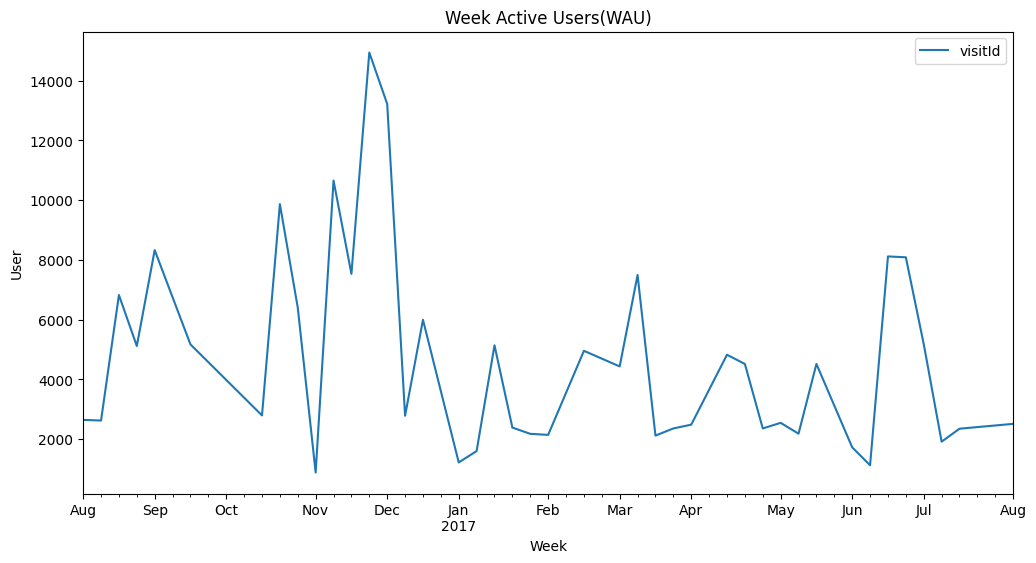

In [421]:
df['date_of_Week']=df.visitStartTime.dt.to_period('W')
df_WAU=df.groupby(df['date_of_Week'])['visitId'].nunique()
plt.figure(figsize=(12,6))
df_WAU.plot(kind='line',legend='visitId')
plt.xlabel('Week')
plt.ylabel('User')
plt.legend()
plt.title('Week Active Users(WAU)')

### DAU

Text(0.5, 1.0, 'Month Active Users(MAU)')

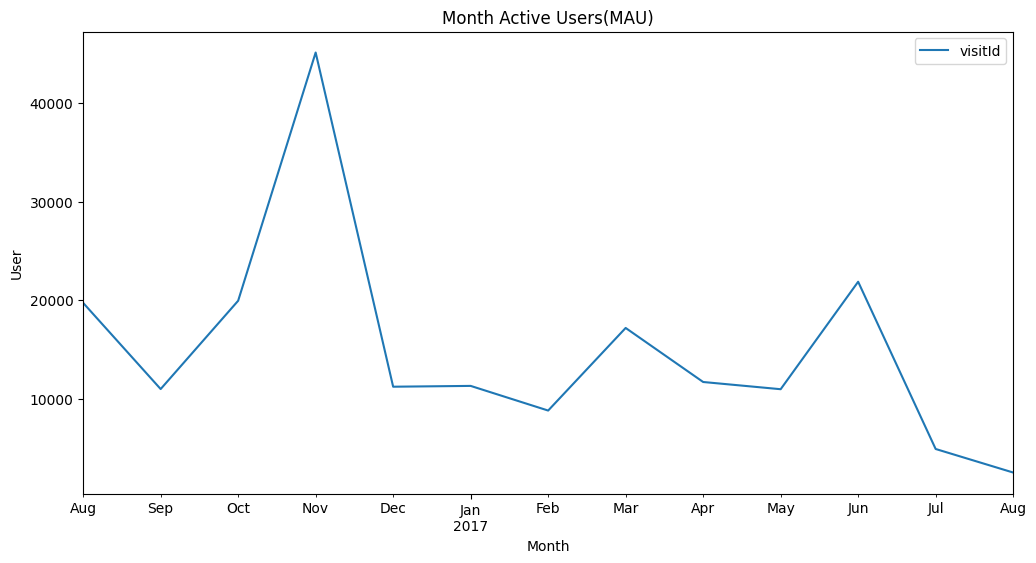

In [423]:
df['date_of_Month']=df.visitStartTime.dt.to_period('M')
df_MAU=df.groupby(df['date_of_Month'])['visitId'].nunique()
plt.figure(figsize=(12,6))
df_MAU.plot(kind='line',legend='visitId')
plt.xlabel('Month')
plt.ylabel('User')
plt.legend()
plt.title('Month Active Users(MAU)')

In [398]:
# 이게 1.0이 나오면 안되는데,,
DAU_MAU_RATIO=df_DAU.sum() / df_MAU.sum()
DAU_MAU_RATIO

1.0

### 첫 방문자와 재 방문자의 비율

In [400]:
first_session = df[df.visitNumber == 1]['visitNumber'].count()
returning_session_ratio  = df[df.visitNumber != 1]['visitNumber'].count()

session_count= df.visitNumber.count()

first_session_ratio = (first_session/session_count * 100).round(2)
print(f"첫 방문자의 비율: {first_session_ratio:.2f}%")

returning_session_ratio  = (returning_session_ratio /session_count * 100).round(2)
print(f"재방문자의 비율: {returning_session_ratio :.2f}%")

첫 방문자의 비율: 78.42%
재방문자의 비율: 21.58%


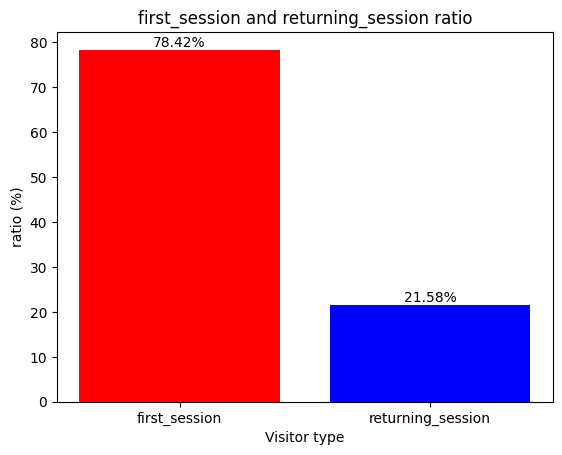

In [428]:
labels = ['first_session', 'returning_session']
ratios = [first_session_ratio, returning_session_ratio]

plt.bar(labels, ratios, color=['red', 'blue'])


plt.title('first_session and returning_session ratio')
plt.xlabel('Visitor type')
plt.ylabel('ratio (%)')
plt.text(0, ratios[0]+0.7, f'{ratios[0]}%', ha='center')
plt.text(1, ratios[1]+0.7, f'{ratios[1]}%', ha='center')

# 그래프 출력
plt.show()